In [ ]:
!pwd

/content/est


#**Prétraitement de la Data**

In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET
import glob
import os


_dir='est'


elements = ['Image','height','width','depth','coin_1','coin_2','coin_3','coin_4']

df=pd.DataFrame(columns=elements)

coin_names = []
coin_values = {}


# Iterate over XML files in the directory
for xml_file in glob.glob('*.xml'):
    if xml_file.endswith('.xml'):
        # Parse the XML file
        print(xml_file)
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Extract the annotation file name
        file_name = root.find('filename').text

        # Extract size information
        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)
        depth = int(root.find('size/depth').text)


        # Iterate over the 'object' elements
        for obj in root.iter('object'):
            # Extract the coin name
            coin_name = obj.find('name').text

            # Extract the coin value (xmin, ymin, xmax, ymax)
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            # Store the coin value in the dictionary
            coin_values[coin_name] = (xmin, xmax, ymin, ymax)

        tmp_df=pd.DataFrame([coin_values], columns=['Image','height','width','depth'] + list(coin_values.keys()))
        # Set the 'filename' column value
        tmp_df['Image'] = file_name
        tmp_df['height']=height
        tmp_df['width']=width
        tmp_df['depth']=depth
        # Append the data to the DataFrame
        df = pd.concat([df,tmp_df], ignore_index=True)



# Print the DataFrame
print(df.describe)

40.xml
0.xml
10.xml
5.xml
26.xml
16.xml
44.xml
13.xml
35.xml
25.xml
43.xml
15.xml
27.xml
41.xml
4.xml
1.xml
20.xml
31.xml
24.xml
19.xml
47.xml
3.xml
42.xml
38.xml
45.xml
22.xml
17.xml
36.xml
9.xml
21.xml
12.xml
34.xml
6.xml
18.xml
11.xml
33.xml
14.xml
46.xml
32.xml
2.xml
23.xml
29.xml
30.xml
39.xml
7.xml
28.xml
37.xml
8.xml
<bound method NDFrame.describe of      Image height width depth                coin_1                coin_2  \
0   40.jpg    448   448     3    (59, 59, 259, 259)    (82, 82, 397, 397)   
1    0.jpg    448   448     3      (77, 77, 73, 73)    (17, 17, 245, 245)   
2   10.jpg    448   448     3    (78, 78, 341, 341)    (20, 20, 186, 186)   
3    5.jpg    448   448     3  (149, 149, 299, 299)  (112, 112, 230, 230)   
4   26.jpg    448   448     3    (84, 84, 290, 290)    (23, 23, 166, 166)   
5   16.jpg    448   448     3  (101, 101, 249, 249)    (39, 39, 147, 147)   
6   44.jpg    448   448     3    (49, 49, 141, 141)      (75, 75, 80, 80)   
7   13.jpg    448   448 

In [ ]:
print([df[df[f'coin_{i}'].apply(lambda x: x[2]) != df[f'coin_{i}'].apply(lambda x: x[3])] for i in range(1,5)])
print(df[df.height<448])

[Empty DataFrame
Columns: [Image, height, width, depth, coin_1, coin_2, coin_3, coin_4]
Index: [], Empty DataFrame
Columns: [Image, height, width, depth, coin_1, coin_2, coin_3, coin_4]
Index: [], Empty DataFrame
Columns: [Image, height, width, depth, coin_1, coin_2, coin_3, coin_4]
Index: [], Empty DataFrame
Columns: [Image, height, width, depth, coin_1, coin_2, coin_3, coin_4]
Index: []]
Empty DataFrame
Columns: [Image, height, width, depth, coin_1, coin_2, coin_3, coin_4]
Index: []


In [ ]:
import matplotlib.pyplot as plt
import cv2

images=df.Image

# Visualize images and their corresponding angle points
for i in range(len(images)):
    image = cv2.imread(images[i])
    angle = [df.loc[i,f'coin_{x}'] for x in range(1,5)]

    # Plot image with angle points
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for p in angle:
        plt.scatter([p[0],p[1]], [p[2],p[3]], color='red')  # Plot the x and y coordinates separately
        # Draw a line between the two points
        plt.plot()
    # Draw lines between the angle points
    for j in [0,2]:
        x_coords = [angle[j][0], angle[j + 1][0]]  # x-coordinates
        y_coords = [angle[j][2], angle[j + 1][2]]  # y-coordinates
        x_c00rds = [angle[j][0],angle[j][0]]
        y_c00rds = [448,0]
        plt.plot(x_coords, y_coords, color='blue')
        plt.plot(x_c00rds, y_c00rds, color='green')
    plt.title('Teeth Image with Angle Points')
    plt.show()

In [ ]:
import cv2
import numpy as np

images = df.Image
output_folder=_dir+'/masks'

# Set the output folder to save the resulting images
os.makedirs(output_folder, exist_ok=True)

# Visualize images and their corresponding angle points
for i in range(len(images)):
    image = cv2.imread(images[i])
    mask = np.zeros_like(image)
    angle = [df.loc[i, f'coin_{x}'] for x in range(1, 5)]

    # Plot image with angle points and lines
    #for p in angle:
        #cv2.circle(mask, (p[0], p[2]), 3, (0, 0, 255), -1)  # Draw red circles at angle points

    # Draw lines between the angle points
    for j in [0, 2]:
        x_coords = [angle[j][0], angle[j + 1][0]]  # x-coordinates
        y_coords = [angle[j][2], angle[j + 1][2]]  # y-coordinates
        cv2.line(mask, (x_coords[0], y_coords[0]), (x_coords[1], y_coords[1]), (255, 255, 255), 2)  # Draw blue lines

    # Prepare mask for augmentation
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)  # Convert mask to grayscale
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

    # Save the resulting image
    output_path = os.path.join(output_folder, f'mask_{images[i][:-4]}.jpg')
    cv2.imwrite(output_path, mask)


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

images = df.Image

# Visualize images and their corresponding angle points
for i in range(len(images)):
    image = cv2.imread(images[i])
    angle = [df.loc[i, f'coin_{x}'] for x in range(1, 5)]

    # Plot image with angle points
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Plot scatter points
    for p in angle:
        plt.scatter([p[0], p[1]], [p[2], p[3]], color='red')

    angs=[]

    # Draw lines between the angle points
    for j in [0,2]:
        x_coords = [angle[j][0], angle[j + 1][0]]  # x-coordinates
        y_coords = [angle[j][2], angle[j + 1][2]]  # y-coordinates
        plt.plot(x_coords, y_coords, color='blue')

        # Calculate angle between two lines
        # Define the starting points of the two lines
        line1_start = np.array([angle[j][0], angle[j][2]])
        line2_start = np.array([angle[j+1][0], 448])

        # Define the ending points of the two lines
        line1_end = np.array([angle[j+1][0], angle[j+1][2]])
        line2_end = np.array([angle[j+1][0], 0])

        # Calculate the direction vectors of the two lines
        line1_vector = line1_end - line1_start
        line2_vector = line2_end - line2_start

        dot_product = np.dot(line1_vector, line2_vector)
        magnitude_product = np.linalg.norm(line1_vector) * np.linalg.norm(line2_vector)
        angle_rad = np.arccos(dot_product / magnitude_product)
        angle_deg = np.degrees(angle_rad)
        angs.append(angle_deg)

    plt.title(f'Teeth Image {images[i][:-4]} with Angle Points')
    plt.text(10, 10, f'Angle 1: {angs[0]:.2f} degrees', color='red') if angs[0] < 180 else  plt.text(10, 10, f'Angle: {angs[0]-360:.2f} degrees', color='red')
    plt.text(238, 10, f'Angle 2: {angs[1]:.2f} degrees', color='red') if angs[1] < 180 else  plt.text(10, 10, f'Angle: {angs[1]-360:.2f} degrees', color='red')
    #df.loc[i, 'Angle 1'] = angs[0] if angs[0] < 180 else angs[0]-180
    #df.loc[i, 'Angle 2'] = angs[1] if angs[1] < 180 else angs[1]-180
    plt.show()

In [ ]:
!pwd

/content/est


In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load images and masks
images = []
masks = []


for im in df.Image:
    mask_path = f'./est/masks/mask_{im[:-4]}.jpg'

    image = cv2.imread(im)
    mask = cv2.imread(mask_path)

    images.append(image)
    masks.append(mask)

In [ ]:
type(mask)

numpy.ndarray

In [ ]:
# Display images and masks side by side
for image, mask in zip(images, masks):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')

    # Display the mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')

    plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an image data generator with desired augmentations
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)

# Generate augmented images and masks
augmented_images = []
augmented_masks = []

for image, mask in zip(images, masks):
    image_batch = np.expand_dims(image, axis=0)
    mask_batch = np.expand_dims(mask, axis=0)

    # Apply data augmentation to images
    augmented_image_batch = data_generator.flow(image_batch, batch_size=1, shuffle=False)

    # Apply data augmentation to masks (use the same seed for consistency)
    augmented_mask_batch = data_generator.flow(mask_batch, batch_size=1, shuffle=False)

    augmented_image = next(augmented_image_batch)[0]
    augmented_mask = next(augmented_mask_batch)[0]

    augmented_images.append(augmented_image)
    augmented_masks.append(augmented_mask)

augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Check the shapes of augmented images and masks
print(f'Augmented Images Size : {augmented_images.size}, Shape : {augmented_images.shape}')
print(f'Augmented Masks Size : {augmented_masks.size}, Shape : {augmented_masks.shape}')

Augmented Images Size : 28901376, Shape : (48, 448, 448, 3)
Augmented Masks Size : 28901376, Shape : (48, 448, 448, 3)


In [ ]:
from sklearn.model_selection import train_test_split


# Modify the masks to have a single channel
augmented_masks_single_channel = augmented_masks[..., 0:1]
# Split the augmented data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(augmented_images, augmented_masks_single_channel, test_size=0.2, random_state=42)

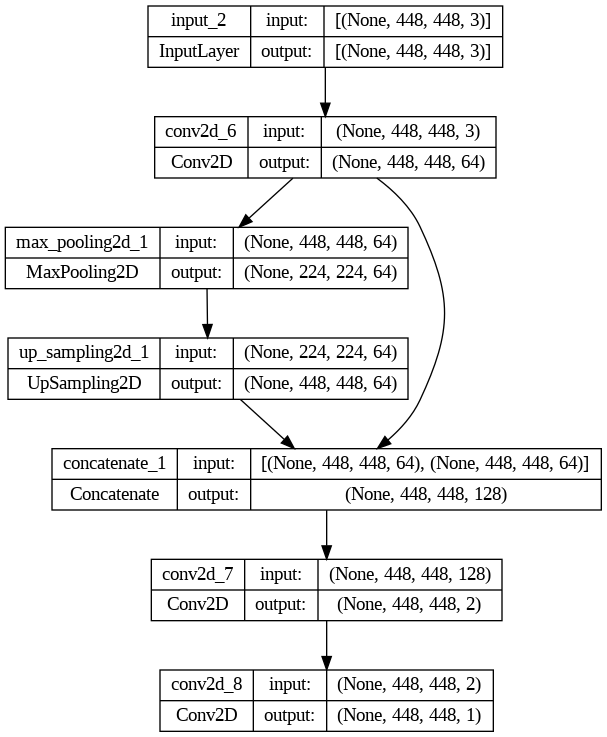

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.utils import plot_model


def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoding path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # Add more convolutional and pooling layers as needed

    # Decoding path
    up6 = UpSampling2D(size=(2, 2))(pool1)
    merge6 = Concatenate(axis=3)([conv1, up6])
    conv6 = Conv2D(2, 3, activation='relu', padding='same')(merge6)
    # Add more upsampling and concatenation layers as needed

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv6)

    model = Model(inputs=inputs, outputs=outputs)
    return model


# Build the U-Net model
input_shape = images[0].shape
model = unet_model(input_shape)


plot_model(model, to_file="cnn.png", show_shapes=True)

In [ ]:
# Build the U-Net model
input_shape = images[0].shape
model = unet_model(input_shape)

# Entraînement du modèle

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')
# Train the model
model.fit(train_images, train_masks, batch_size=8, epochs=10, validation_data=(val_images, val_masks))

In [ ]:
# Evaluate the model
eval_loss = model.evaluate(val_images, val_masks)
print("Evaluation Loss:", eval_loss)

1/1 [==============================] - 6s 6s/step - loss: 0.6797
Evaluation Loss: 0.6797093749046326


In [ ]:
# Perform inference on new images
new_image_path = '10.jpg'
new_image = cv2.imread(new_image_path)

# Preprocess the new image
new_image = np.expand_dims(new_image, axis=0)

# Predict line mask
line_mask = model.predict(new_image)

# Threshold the line mask
threshold = 0.5
thresholded_mask = (line_mask > threshold).astype(np.uint8)

# Perform post-processing if needed (e.g., morphological operations or line fitting)

# Visualize the line mask


from google.colab.patches import cv2_imshow
cv2_imshow(thresholded_mask[0] * 255)